In [3]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-17 15:44:17--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.1s    

2025-10-17 15:44:17 (717 KB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [6]:
df = pd.read_csv('course_lead_scoring.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [8]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

missing_counts = df.isnull().sum()
print('Missing values per column:')
print(missing_counts[missing_counts > 0])

if missing_counts.sum() > 0:
    df[cat_cols] = df[cat_cols].fillna('NA')
    df[num_cols] = df[num_cols].fillna(0.0)
    print()

print()
print('Total remaining missing values:', int(df.isnull().sum().sum()))


Missing values per column:
Series([], dtype: int64)

Total remaining missing values: 0


In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(f'Train size: {len(df_train)}')
print(f'Validation size: {len(df_val)}')
print(f'Test size: {len(df_test)}')


Train size: 876
Validation size: 293
Test size: 293


In [10]:
cat = ['lead_source', 'industry', 'employment_status', 'location']
num = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [11]:
from sklearn.metrics import roc_auc_score

y_train = df_train['converted']
num_features = [col for col in df_train.select_dtypes(include=[np.number]).columns if col != 'converted']

auc_results = []
for feature in num_features:
    scores = df_train[feature]
    if scores.nunique() < 2:
        auc_results.append((feature, float('nan'), 'constant'))
        continue

    auc = roc_auc_score(y_train, scores)
    direction = 'original'
    if auc < 0.5:
        auc = roc_auc_score(y_train, -scores)
        direction = 'negated'

    auc_results.append((feature, auc, direction))

for feature, auc, direction in sorted(
    auc_results,
    key=lambda x: (x[1] if not np.isnan(x[1]) else -1),
    reverse=True,
):
    if np.isnan(auc):
        print(f'{feature}: skipped (constant feature)')
    else:
        print(f'{feature}: AUC={auc:.3f} ({direction})')


number_of_courses_viewed: AUC=0.764 (original)
interaction_count: AUC=0.738 (original)
lead_score: AUC=0.614 (original)
annual_income: AUC=0.552 (original)


In [12]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[cat + num].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [13]:
val_dict = df_val[cat + num].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(df_val['converted'].values == churn_decision).mean()

np.float64(0.6996587030716723)

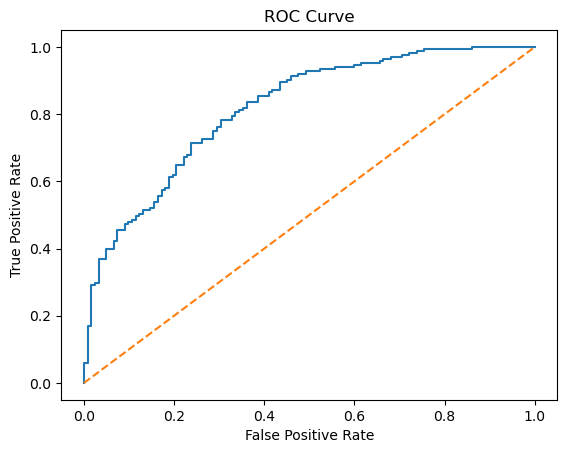

In [14]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(df_val['converted'], y_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [15]:
from sklearn.metrics import auc
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.3f}')

ROC AUC: 0.817
